In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

import shap
import category_encoders as ce
import xgboost as xgb

C:\Users\83995\.conda\envs\capstone\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df_nasdaq = pd.read_csv('df_nasdaq.csv')
df_sp500 = pd.read_csv('df_sp500.csv')
df_dji = pd.read_csv('df_dji.csv')

In [4]:
target = 'Close'
y = df_nasdaq[target]
X = df_nasdaq.drop(columns=[target, 'Date'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=7600)

In [5]:
encoder = ce.LeaveOneOutEncoder(return_df=True)
X_train_loo = encoder.fit_transform(X_train, y_train)
X_test_loo = encoder.transform(X_test)

In [6]:
X_train_loo

,Open,High,Low,Adj Close,Volume,DailyReturn,MA_10,MA_20,MA_50,EMA_100,EMA_200,Volatility_bbh,Volatility_bbl,MACD,RSI,ATR,OBV
851,12239.690430,12426.259766,12181.129883,12390.690430,4907410000,0.018754,11879.551172,11622.631543,11531.976641,12281.457868,12956.955388,12328.769217,10916.493869,173.858046,64.318067,296.728536,411712150000
726,13436.709961,13771.910156,13236.559570,13770.570312,4971930000,0.031289,13972.374023,14601.631982,15181.703984,14976.939727,14568.946806,16134.381091,13068.882874,-498.325257,34.425290,394.798215,429650920000
647,14289.450195,14509.549805,14259.070312,14501.910156,4465910000,0.004717,14633.553125,14829.359082,14886.182793,14521.456101,13839.277715,15442.716056,14216.002108,-149.679109,41.058222,217.283304,390441150000
1215,14877.700195,14998.200195,14842.700195,14969.650391,4404590000,0.007534,14826.931934,14841.476953,14293.804453,14023.482203,13520.885609,15223.896674,14459.057232,136.126334,61.489919,172.050037,472940510000
252,7610.390137,7875.930176,7219.089844,7874.879883,4701070000,0.093460,8329.221924,8810.119995,9123.018584,8797.109874,8478.515103,10247.940657,7372.299333,-403.687093,38.670169,356.778392,98206720000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1224,15560.610352,15629.070312,15468.910156,15481.919922,4983210000,0.003629,15134.734082,14986.079004,14625.255020,14211.293997,13661.817729,15533.325230,14438.832778,212.864908,72.562656,176.292854,498215740000
288,8809.660156,8909.959961,8781.309570,8809.120117,3933550000,0.011298,8689.158008,8506.556030,8126.682012,8450.534809,8352.327620,9051.192540,7961.919521,203.636092,58.422750,253.335282,103386200000
48,7749.799805,7786.330078,7738.350098,7750.839844,1884660000,-0.004480,7798.445947,7939.377979,7882.827773,7592.319676,7291.132923,8273.439454,7605.316503,-46.382425,42.662068,116.346361,49841190000
494,13406.160156,13596.589844,13362.660156,13588.830078,5079530000,0.030054,13624.963965,13729.974951,13319.155781,12674.252408,11712.165779,14306.692851,13153.257052,27.991893,51.312170,273.155260,352128320000


In [7]:
model = xgb.XGBRegressor(n_estimators=500, max_depth=5, eta=0.05)
model.fit(X_train_loo, y_train)

rmse = np.sqrt(mean_squared_error(y_test, model.predict(np.ascontiguousarray(X_test_loo))))
rmse

30.75168732874618

Text(0.5, 1.0, 'Feature Importance')

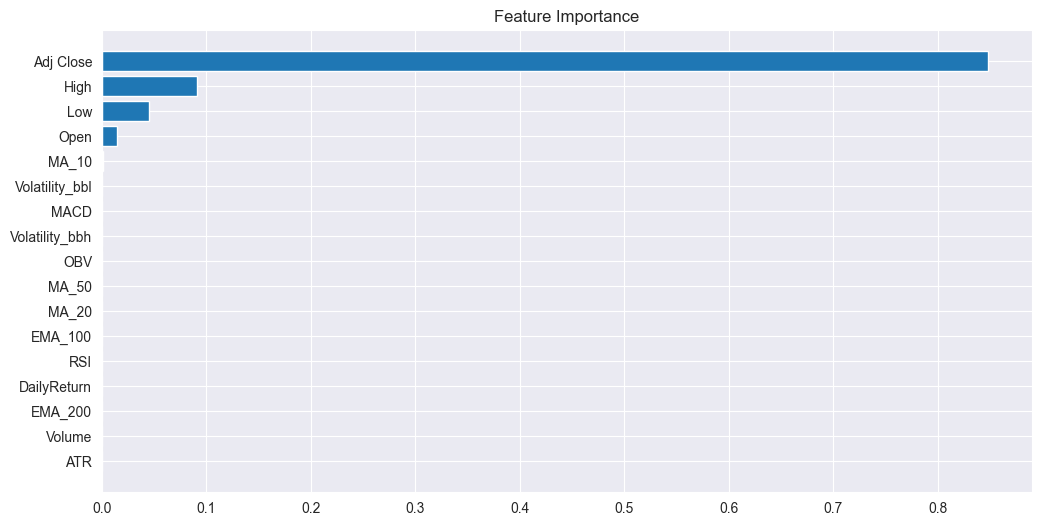

In [8]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

Text(0.5, 1.0, 'SHAP Importance')

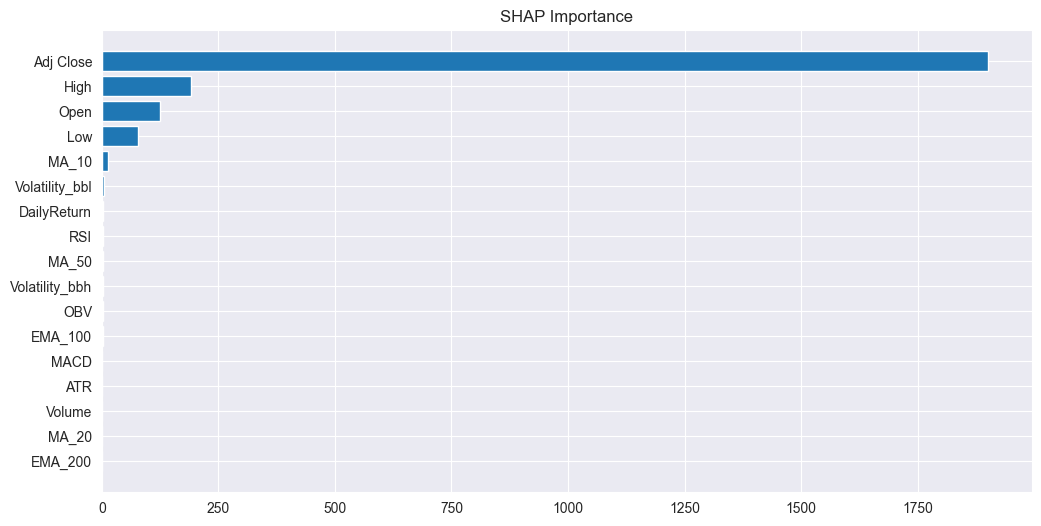

In [9]:
explainer = shap.Explainer(model)
shap_values = explainer(np.ascontiguousarray(X_test_loo))
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('SHAP Importance')